In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import math
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from sklearn import cross_validation
from time import time
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report

In [2]:
df = pd.read_table('../data/brcaTrainExpr.txt', index_col = 'GENE')
df = df.transpose()
X = np.array(df)
df.head()

dfT = pd.read_table('../data/brcaTestExpr.txt', index_col = 'GENE')
dfT = dfT.transpose()
XT = np.array(dfT)
dfT.head()

dfy = pd.read_table('../data/brcaTrainPheno.txt')
y = np.where(dfy.RelapseGroup == 'Relapse', 1, 0)
y[:5]

dfyT = pd.read_table('../data/brcaTestPheno.txt')
yT = np.where(dfyT.RelapseGroup == 'Relapse', 1, 0)
yT[:5]

def WRST(X,y): #X is feature matrix, y is binary label vector

    num_zeros = sum(y == 0) # Number of NoRelapse patients
    num_ones = len(y) - num_zeros # Number of Relapse patients
    
    #Use Wilcoxon rank-sum test to find most differentially expressed genes
    W = np.array(range(X.shape[1])) #Create W vector whose length = # of genes (aka number of columns)
    
    for i in range(X.shape[1]): #for each gene
        ranks = ss.rankdata(X[:,i],method='average')  # rank patients from least expressed to most expressed
        
        W[i] = sum(ranks[np.nonzero(y)]) #Add together gene i's rank for all patients who relapse
    
    #For binary label, sum up positive labels & negative labels (this equals the mean)
    # When the two samples are sufficiently large, the W statistic is approximately normal N(μ, σ) where
    m = num_ones * (len(y) + 1) / 2. # mu =  n1 * (n + 1) / 2 and 
    s = math.sqrt((num_zeros * num_ones * (len(y) + 1)) / 12.) # var = n1 * n2 * (n + 1) / 12
    
    pval = np.array(range(X.shape[1]), float) # Create empty pval array
    
    #calculate p-values for each gene
    for i in range(len(W)):
        if W[i] <= m:
            pval[i] = 2.*ss.norm.cdf(W[i],m,s)
        else:
            pval[i] = 2.*(1-ss.norm.cdf(W[i],m,s))
    
    #sort p-values
    sort = np.argsort(pval)
    
    return sort

sort = WRST(X, y)

dfw = df[df.columns[sort]]
dfTw = dfT[dfT.columns[sort]]
Xw = np.array(dfw)
XTw = np.array(dfTw)

In [3]:
cv_params = {'max_depth': [5, 7, 9], 'max_features':['sqrt','log2'], 'class_weight': ['balanced','balanced_subsample']}
ind_params = {'n_jobs':-1,'n_estimators': 7500}
optimizing_rf = GridSearchCV(RandomForestClassifier(**ind_params), cv_params, cv = 5, n_jobs = -1)
% time optimizing_rf.fit(Xw[:,:1000], y)
ind_params.update(optimizing_rf.best_params_)
optimized_rf = RandomForestClassifier(**ind_params)
optimized_rf.fit(Xw[:,:1000], y)

CPU times: user 48.9 s, sys: 2.07 s, total: 51 s
Wall time: 1h 15min 30s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=7500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [4]:
rf_pp = optimized_rf.predict_proba(XTw[:,:1000])
print('Null Accuracy:', 137./212)
print('RF Accuracy  :', optimized_rf.score(XTw[:,:1000], yT))
print('')
print(classification_report(yT, optimized_rf.predict(XTw[:,:1000]), labels=[1,0]))
print('')
conmat = np.array(confusion_matrix(yT, optimized_rf.predict(XTw[:,:1000]), labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Relapse', 'NoRelapse'],
                         columns=['predicted_Relapse','predicted_NoRelapse'])
confusion

('Null Accuracy:', 0.6462264150943396)
('RF Accuracy  :', 0.66981132075471694)

             precision    recall  f1-score   support

          1       0.67      0.13      0.22        75
          0       0.67      0.96      0.79       137

avg / total       0.67      0.67      0.59       212




,predicted_Relapse,predicted_NoRelapse
Relapse,10,65
NoRelapse,5,132


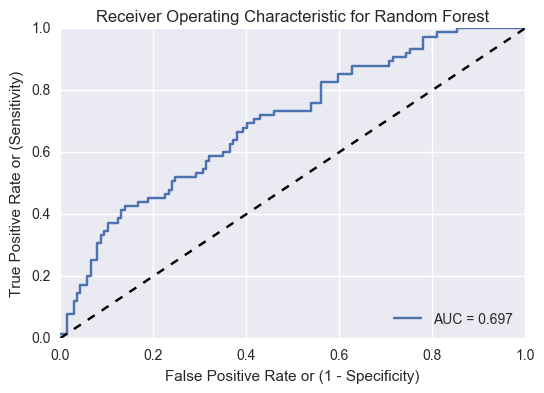

0.697323600973

219000_s_at;DSCC1


In [5]:
fpr, tpr, thresholds = roc_curve(yT, rf_pp[:,1])
roc_auc = auc(fpr, tpr)
%matplotlib inline
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate or (1 - Specificity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic for Random Forest')
plt.legend(loc="lower right")
plt.show()
plt.savefig('rf_roc.png')
print(roc_auc)
print('')
# the most important feature
print(dfw.columns[np.argmax(optimized_rf.feature_importances_)])

In [7]:
sort_ix = sorted(range(len(optimized_rf.feature_importances_)), key=lambda i: optimized_rf.feature_importances_[i], reverse=True)

In [8]:
for i in range(5):
    print(dfw.columns[sort_ix[i]])

219000_s_at;DSCC1
208696_at;CCT5
220475_at;SLC28A3
222231_s_at;LRRC59
222077_s_at;RACGAP1


In [6]:
print 'Sensitivity/Recall/TPR (Correct Relapse Predictions / Total Relapse):', float(conmat[0][0]) / conmat.sum(axis=1)[0]
print ''
print 'Specificity/TNR (Correct NoRelapse Predictions / Total NoRelapse):', float(conmat[1][1]) / conmat.sum(axis=1)[1]
print ''
print 'Precision (Correct Relapse Predictions / Total Relapse Predictions):', float(conmat[0][0]) / conmat.sum(axis=0)[0]
print ''
print 'FPR (Incorrect Relapse Predictions / Total NoRelapse):', float(conmat[1][0]) / conmat.sum(axis=1)[1]

Sensitivity/Recall/TPR (Correct Relapse Predictions / Total Relapse): 0.133333333333

Specificity/TNR (Correct NoRelapse Predictions / Total NoRelapse): 0.963503649635

Precision (Correct Relapse Predictions / Total Relapse Predictions): 0.666666666667

FPR (Incorrect Relapse Predictions / Total NoRelapse): 0.036496350365
